# Content Based Filtering - Feature Engineering

In [236]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [237]:
credits = pd.read_csv('tmdb_5000_credits.csv')

In [238]:
credits.columns = ['id','tittle','cast','crew']

In [239]:
movies = pd.read_csv('tmdb_5000_movies.csv')

In [240]:
movies = movies.merge(credits, on='id')


#### Firstly we will be just be working on Overview Column and try to extract features from it and build a protype of recommender system

In [241]:
movies['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

###### Now we'll compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview

Before that we will remove all the stop words and punchuations from overview by defining a funct.

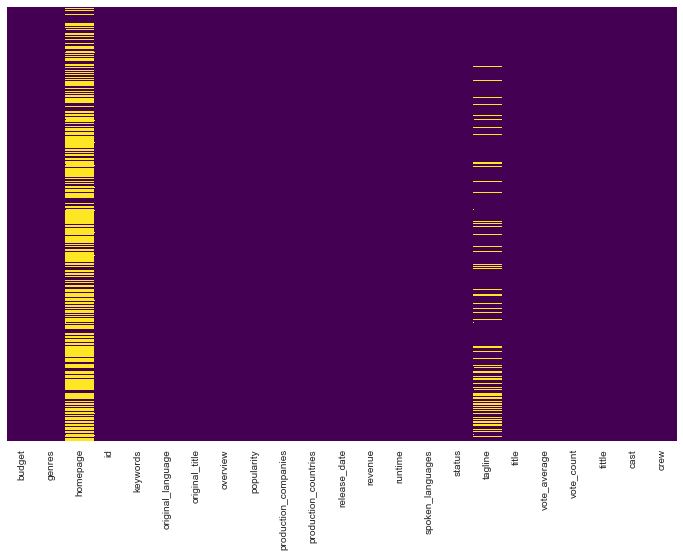

In [242]:
#to find null values
plt.figure(figsize=(12,8))
sns.heatmap(movies.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [243]:
#From map its not possible to check so using isnull funct.
movies['overview'].isnull().sum()

3

In [244]:
#Replace NaN with an empty string
movies['overview'] = movies['overview'].fillna('')

In [245]:
import string
from nltk.corpus import stopwords

In [246]:
def alter(overview):
    
    # Removing Punctuation
    new_str=[char for char in overview if char not in string.punctuation]
    
    #Rejoining Char
    new_str=''.join(new_str)
    
    new1 = ' '
    #removing stop words
    return new1.join([word for word in new_str.split() if word.lower() not in stopwords.words('english')])

In [247]:
movies['overview']=movies['overview'].apply(alter)

In [248]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

In [249]:
tfidf = TfidfVectorizer()

In [250]:
tfidf_matrix = tfidf.fit_transform(movies['overview'])

In [251]:
tfidf_matrix.shape

(4803, 23396)

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. 

Therefore, we will use sklearn's linear_kernel() instead of cosine_similarities() since it is faster.

In [252]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

In [253]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

Now I will define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. 

Firstly, for this, I will do reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [254]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

## Now system is ready for recommendation for movies

#### Some more steps which we have to follow :-

- Making a Function to return list of recommended movie.
- Get the index of the movie given its title.
- Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
- Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
- Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
- Return the titles corresponding to the indices of the top elements.

In [255]:
def recommend_movie(title, cosine_sim=cosine_sim):
    
    # Get the index of the movie of given title
    index= indices[title]
    
    # Get the pairwsie similarity scores of all movies with that movie
    scores = list(enumerate(cosine_sim[index]))
    
    #Sorting values
    sort_scores = sorted(scores,key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 10 most similar movies
    top_10_scores = sort_scores[1:11]
    
    #Get the top 10 movies index
    top_10_movies = [i[0] for i in top_10_scores]
    
    return movies['title'].loc[top_10_movies]
    
    
    
    
    

In [256]:
recommend_movie('The Dark Knight Rises')

428                              Batman Returns
65                              The Dark Knight
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
299                              Batman Forever
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
210                              Batman & Robin
1398                                  Max Payne
Name: title, dtype: object

In [257]:
recommend_movie('The Avengers')

7                   Avengers: Age of Ultron
3144                                Plastic
1715                                Timecop
4124                     This Thing of Ours
85      Captain America: The Winter Soldier
588         Wall Street: Money Never Sleeps
3033                          The Corruptor
2136             Team America: World Police
256                               Allegiant
2433       Superman IV: The Quest for Peace
Name: title, dtype: object

##### So recommended system is working pretty well.

But the thing which should be noticed here is that "The Dark Knight Rises" returns all Batman movies while it is more likely that the people who liked that movie are more inclined to enjoy other Christopher Nolan movies. This is something that cannot be captured by the present system.

## To optimize this I will make Credits, Genres and Keywords Based Recommender

- Better metadata. That is exactly what we are going to do in this section.
- I will be usig metadata: the 3 top actors, the director, related genres and the movie plot keywords.

Our data is present in the form of "stringified" lists , we need to convert it into a safe and usable structure.

In [258]:
movies.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,22nd century paraplegic Marine dispatched moon...,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,Captain Barbossa long believed dead come back ...,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,cryptic message Bond’s past sends trail uncove...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following death District Attorney Harvey Dent ...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,John Carter warweary former military captain w...,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [259]:
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    movies[feature] = movies[feature].apply(literal_eval)

In [260]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,22nd century paraplegic Marine dispatched moon...,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de..."
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,Captain Barbossa long believed dead come back ...,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de..."


In [261]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [262]:
# Returns the list top 3 elements or entire list; whichever is more.

def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
            return names
        return names
    #Return empty list in case of missing/malformed data
    return []

In [263]:
movies['director'] = movies['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    movies[feature] = movies[feature].apply(get_list)

In [264]:
# Print the new features of the first 3 films
movies[['title', 'cast', 'director', 'keywords', 'genres']].head(5)


,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"
3,The Dark Knight Rises,"[Christian Bale, Michael Caine, Gary Oldman]",Christopher Nolan,"[dc comics, crime fighter, terrorist]","[Action, Crime, Drama]"
4,John Carter,"[Taylor Kitsch, Lynn Collins, Samantha Morton]",Andrew Stanton,"[based on novel, mars, medallion]","[Action, Adventure, Science Fiction]"


The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. 

This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.



In [265]:
def space_remove(x):
    if isinstance(x,list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
       #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return '' 

In [266]:
# space_remove function to our features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    movies[feature] = movies[feature].apply(space_remove)

In [267]:
movies[['cast', 'keywords', 'director', 'genres']].head(2)

,cast,keywords,director,genres
0,"[samworthington, zoesaldana, sigourneyweaver]","[cultureclash, future, spacewar]",jamescameron,"[action, adventure, fantasy]"
1,"[johnnydepp, orlandobloom, keiraknightley]","[ocean, drugabuse, exoticisland]",goreverbinski,"[adventure, fantasy, action]"


#### Now to feed data into vectorizer we have to combine all the strings. I will now create 'Metadata Soup'

In [268]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

movies['soup'] = movies.apply(create_soup, axis=1)

In [269]:
movies['soup']

0       cultureclash future spacewar samworthington zo...
1       ocean drugabuse exoticisland johnnydepp orland...
2       spy basedonnovel secretagent danielcraig chris...
3       dccomics crimefighter terrorist christianbale ...
4       basedonnovel mars medallion taylorkitsch lynnc...
                              ...                        
4798    unitedstates–mexicobarrier legs arms carlosgal...
4799     edwardburns kerrybishé marshadietlein edwardb...
4800    date loveatfirstsight narration ericmabius kri...
4801       danielhenney elizacoupe billpaxton danielhsia 
4802    obsession camcorder crush drewbarrymore brianh...
Name: soup, Length: 4803, dtype: object

#### I will be using CountVectorizer() instead of TF-IDF. 

- This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense

In [270]:
from sklearn.feature_extraction.text import CountVectorizer

In [271]:
count = CountVectorizer(stop_words='english')

In [272]:
count_matrix = count.fit_transform(movies['soup'])

In [273]:
#Cosine Similarity matrix based on the count_matrix

from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_new = cosine_similarity(count_matrix, count_matrix)

In [274]:
pd.DataFrame(cosine_sim_new)

,0,1,2,3,4,5,6,7,8,9,...,4793,4794,4795,4796,4797,4798,4799,4800,4801,4802
0,1.000000,0.300000,0.200000,0.100000,0.200000,0.300000,0.0,0.200000,0.2,0.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.095346,0.000000,0.000000,0.0,0.0
1,0.300000,1.000000,0.200000,0.100000,0.200000,0.300000,0.0,0.200000,0.2,0.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.095346,0.000000,0.000000,0.0,0.0
2,0.200000,0.200000,1.000000,0.200000,0.300000,0.200000,0.0,0.200000,0.1,0.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.190693,0.000000,0.000000,0.0,0.0
3,0.100000,0.100000,0.200000,1.000000,0.100000,0.100000,0.0,0.100000,0.0,0.200000,...,0.111803,0.000000,0.105409,0.091287,0.000000,0.190693,0.000000,0.100000,0.0,0.0
4,0.200000,0.200000,0.300000,0.100000,1.000000,0.200000,0.0,0.300000,0.1,0.200000,...,0.000000,0.000000,0.000000,0.091287,0.000000,0.095346,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,0.095346,0.095346,0.190693,0.190693,0.095346,0.095346,0.0,0.095346,0.0,0.095346,...,0.000000,0.106600,0.000000,0.087039,0.174078,1.000000,0.000000,0.000000,0.0,0.0
4799,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,1.000000,0.223607,0.0,0.0
4800,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.111803,0.111803,0.105409,0.091287,0.000000,0.000000,0.223607,1.000000,0.0,0.0
4801,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0


In [275]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,status,tagline,title,vote_average,vote_count,tittle,cast,crew,director,soup
0,237000000,"[action, adventure, fantasy]",http://www.avatarmovie.com/,19995,"[cultureclash, future, spacewar]",en,Avatar,22nd century paraplegic Marine dispatched moon...,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[samworthington, zoesaldana, sigourneyweaver]","[{'credit_id': '52fe48009251416c750aca23', 'de...",jamescameron,cultureclash future spacewar samworthington zo...
1,300000000,"[adventure, fantasy, action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drugabuse, exoticisland]",en,Pirates of the Caribbean: At World's End,Captain Barbossa long believed dead come back ...,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[johnnydepp, orlandobloom, keiraknightley]","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",goreverbinski,ocean drugabuse exoticisland johnnydepp orland...


In [276]:
# Now we will create reverse mapping of title and indices
indices = pd.Series(movies.index, index=movies['title'])

In [277]:
indices

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [278]:
# Using our previously defined recommended movie function with new cosine_sim_new matrix

recommend_movie('The Dark Knight Rises', cosine_sim_new)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title, dtype: object

In [279]:
recommend_movie('The Godfather', cosine_sim_new)

867      The Godfather: Part III
2731      The Godfather: Part II
4638    Amidst the Devil's Wings
2649           The Son of No One
1525              Apocalypse Now
1018             The Cotton Club
1170     The Talented Mr. Ripley
1209               The Rainmaker
1394               Donnie Brasco
1850                    Scarface
Name: title, dtype: object

## We are succesful in making our recommendation system.

We can more add features to the engine to make it more effective and simultaneously we can add more weight to existing features by repeating them.
##### The Contest based recoomender has done preety well but It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres. And this recommender is general, it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

# To overcome this I will be making Collaborative Filtering Recommender